In [1]:
import pandas as pd
import matplotlib.pyplot as plt

bank_failure_data = pd.read_excel('Bank failure data.xlsx')
bank_failure_data.head()

,Bank Name,Quarter,Tier One,Texas,Size,Brokered Deposits,Net Chargeoffs,Constr and Land Dev Loans,Change in Portfolio Mix,NP CRE to Assets,Volatile Liabilities to Assets,Securities,Failed during 2010Q2,Cert Number
0,Exchange Bank,2007Q4,14.90,19.36,32.852108,0.0,0.03,23.13,3.38,0.190681,20.16,99.07,No,160
1,Exchange Bank,2008Q1,14.30,20.86,33.542390,0.0,0.00,32.96,4.96,0.000000,21.23,99.45,No,160
2,Exchange Bank,2008Q2,14.15,20.89,34.140007,0.0,0.31,33.71,1.53,0.022408,19.69,97.94,No,160
3,Exchange Bank,2008Q3,14.13,18.74,34.038758,0.0,-0.02,34.99,3.80,0.147452,19.83,98.84,No,160
4,Exchange Bank,2008Q4,14.21,21.82,34.059328,0.0,1.21,37.14,3.86,0.057306,15.29,99.84,No,160


In [2]:
null_columns = bank_failure_data.columns[bank_failure_data.isnull().any()]
null_columns


Index(['Texas', 'Brokered Deposits', 'Net Chargeoffs'], dtype='object')

In [3]:
bank_failure_data['Texas'] = bank_failure_data['Texas'].interpolate(method='linear')
bank_failure_data['Brokered Deposits'] = bank_failure_data['Brokered Deposits'].interpolate(method='linear')
bank_failure_data['Net Chargeoffs'] = bank_failure_data['Net Chargeoffs'].interpolate(method='linear')
#filling the null columns with linear interpolation


# What was the biggest bank at the end of 2009? 

In [4]:
bank_failure_data[bank_failure_data.index == bank_failure_data[bank_failure_data['Quarter'] == '2009Q4']['Size'].idxmax()]


,Bank Name,Quarter,Tier One,Texas,Size,Brokered Deposits,Net Chargeoffs,Constr and Land Dev Loans,Change in Portfolio Mix,NP CRE to Assets,Volatile Liabilities to Assets,Securities,Failed during 2010Q2,Cert Number
2618,"Citibank (South Dakota), N.A.",2009Q4,12.78,0.15,99.777234,95.78,5.66,0.0,25.28,0.0,18.37,107.54,No,23360


# What trends do you observe in net chargeoffs over time? 

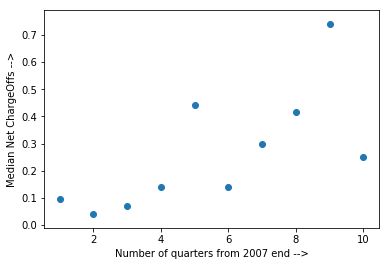

In [5]:
y = bank_failure_data['Net Chargeoffs'].groupby([bank_failure_data['Quarter']])

x = pd.DataFrame({ '' : range(1, len(y) + 1 ,1)})
plt.xlabel("Number of quarters from 2007 end -->")
plt.ylabel("Median Net ChargeOffs -->")
plt.scatter(x,y.median())


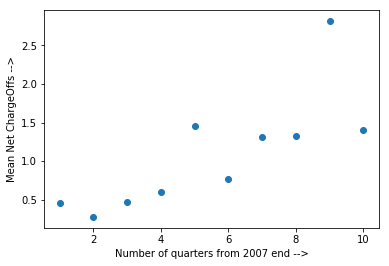

In [6]:
x = pd.DataFrame({ '' : range(1, len(y) + 1 ,1)})
plt.xlabel("Number of quarters from 2007 end -->")
plt.ylabel("Mean Net ChargeOffs -->")
plt.scatter(x,y.mean())


In [ ]:
As shown above in the scatter plots of Mean and median, the net charge offs versus the number of quarters from 2007 
end generally increase over time.

# Is there a correlation between level of profitability of a bank’s investments in securities (here measured by fair value of investments over cost basis) and bank failure? 

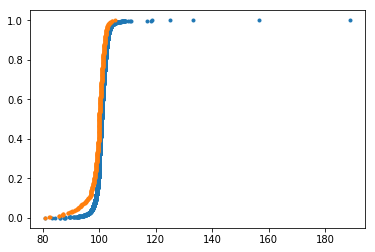

In [7]:
import numpy as np
bank_failure_data['Failed during 2010Q2'].replace(('Yes', 'No'), (1, 0), inplace=True)

failed_bank_rows = bank_failure_data.loc[bank_failure_data['Failed during 2010Q2'] == 0]
passed_bank_rows = bank_failure_data.loc[bank_failure_data['Failed during 2010Q2'] == 1]

x1 = np.sort(failed_bank_rows['Securities'])
x2 = np.sort(passed_bank_rows['Securities'])

y1 = np.arange(1,len(x1)+1)/len(x1)
y2 = np.arange(1,len(x2)+1)/len(x2)

plot1 = plt.plot(x1,y1,marker = '.' , linestyle ='none')
plot2 = plt.plot(x2,y2,marker = '.' , linestyle ='none')


In [ ]:
We can see from the above ecdf plot that the banks that have failed have a lower security and their graph is more towards
left as compared to the banks that have not failed.

In [8]:

print('Correlation value between Securities and Bank failure is ' + str(bank_failure_data['Securities'].corr(bank_failure_data['Failed during 2010Q2'])))

Correlation value between Securities and Bank failure is -0.1542227378017763


# What are the top two predictors of bank failure?

In [9]:
from sklearn.feature_selection import SelectKBest,f_classif

predictors = []
for i in bank_failure_data.columns:
    if i not in ["Bank Name","Quarter","Failed during 2010Q2","Cert Number"]:
        predictors.append(i)

X_unscaled = pd.DataFrame(bank_failure_data, columns=predictors)

########## normalizing features before finding best 2 predictors #############
from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(X_unscaled)
X = pd.DataFrame(x_scaled)


In [11]:
selector = SelectKBest(f_classif, k=2)
selector.fit(X,bank_failure_data['Failed during 2010Q2'])

X_new = selector.transform(X)

X.columns[selector.get_support(indices=True)]

vector_names = list(X.columns[selector.get_support(indices=True)])
print("Top 2 predictors are : ")
for i in vector_names:
    print(X_unscaled.columns[i])


Top 2 predictors are : 
Texas
Constr and Land Dev Loans


# Which banks are most likely to fail in the near future (and why)? 

In [12]:
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split
from sklearn import preprocessing
from sklearn import metrics, cross_validation



C:\Users\Deepak Chawla\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [206]:
from sklearn import metrics, cross_validation

logreg=LogisticRegression()

bank_failure_rows_2010 = bank_failure_data.loc[bank_failure_data['Quarter'] == '2010Q1']

X_train, X_test, y_train, y_test = train_test_split(X, bank_failure_data['Failed during 2010Q2'], test_size=0.2)

model = logreg.fit(X_train, y_train)

predicted = cross_validation.cross_val_predict(model,X_test,y_test, cv=10) 
print('Acuracy of the model : ')
print(metrics.accuracy_score(y_test, predicted))

from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test,predicted)
print('\nConfusion matrix : ')
print(confusion_matrix)

probabilities = model.predict_proba(X_test)
failed_bank_indices = bank_failure_data.loc[bank_failure_data['Failed during 2010Q2'] == 1].index

top_picks_indexes = -probabilities[:,1].argsort()[:3]
Y_top_picks = np.zeros(len(X_test))
Y_top_picks[top_picks_indexes] = 1

# print(Y_top_picks)

# count = 5 #printing top 5 banks that are likely to fail
# for i in top_picks_indexes:
#      if i not in failed_bank_indices:
#             print(i)
# #          print(bank_failure_data.loc[i]['Bank Name'])
    

bank_failure_data.iloc[top_picks_indexes]

Acuracy of the model : 
0.9002463054187192

Confusion matrix : 
[[714   7]
 [ 74  17]]


,Bank Name,Quarter,Tier One,Texas,Size,Brokered Deposits,Net Chargeoffs,Constr and Land Dev Loans,Change in Portfolio Mix,NP CRE to Assets,Volatile Liabilities to Assets,Securities,Failed during 2010Q2,Cert Number
3561,FlatIrons Bank,2008Q1,25.71,16.32,17.298686,0.00,0.00,33.18,6.71,0.000000,18.12,101.11,0,57280
3358,Red River Bank,2009Q4,11.80,2.90,47.521313,0.00,0.04,6.94,3.24,0.167234,25.88,101.07,0,34980
3416,Satilla Community Bank,2009Q2,9.49,64.85,31.659556,37.55,2.46,13.05,3.48,2.401118,12.62,100.22,1,35114


In [ ]:
I have built a logistic regression model using the entire dataset and split the entire data set into training and test.
Then i have predicted using 10 fold cross validation to get my final model. I have then found out the top 3 banks that 
have not yet failed but will fail as per my model. Out of the three I have predicted, Satilla bank already did fail and 
other two banks that I have predicted have less texas and Constr and Land Dev Loans. The model I have is biased
simply because of the fact that number of banks that have failed and lie in the one type of class are very less. And so
the model will be skewed towards the banks not failing.